We have a database, that we want to do inference on: 

 > 'How heavy is a baby aged 6 months likely to be?'

```
Age/months  Weight
 0            8.2
 4            6.1
 5            7.1
 8            8.5
 9           10.2
12           10.0
16           25.9
17           26.1
18           23.3
19           27.5
22           26.2
24           28.7
```

To apply differential privacy, we will just release the mean of each block:

```
Age/months  Weight      Noise    Released Weight   Mean Age
 0- 6            7.1     +2.6          9.7           3.0
 7-12            9.6     -7.2          2.4           9.7
13-18           25.1     -6.5         18.6          17.0
19-24           27.5     -0.5         27.0          21.7
```

> ### Notes to self
> - See histogram mechanism for how to improve sensitivity.
> - How can we incorporate the mean of each bin help?: Notice that these averages are problematic as their centre of mass isn't necessarily in the middle of each set. Anyway, ignoring that for now.

Let $x(t) = \int_0^t f(u) \; du$

Where $f(u)$ is a function describing the weight function (over their age, t). $x(t)$ is the integral of this, the values of this we are given by the averages times the sizes of each bin. For example we can say that the integral between 0 and 6 is $9.7 \times 6 = 58.2 \text{kg months}$.

So we want to find the mean and covariance of $f$ given these values of $\mathbf{x}$.

> ### Mistake!
> I've used the above expression for x in this document, however, I realise there's a constant missing!:
>
> First, let:
>
> $\frac{dx}{dt} = f(t)$
>
> Integrating;
>
> $\int 1 \;dx = \int_0^t f(t)\; du$
>
> $x(t) + C = \int_0^t f(u)\; du$
>
> Notice that I've assumed $C$ is zero below!
>
> So how can we make it so $C$ is zero? Let's consider time zero:
>
> $x(0) + C = \int_0^0 f(u)\; du$
>
> So this leaves: $x(0) = -C$
>
> So $C$ will be zero if $x$ is zero at time zero.
>
> In the numerical example below, I've set the example so the gradient would be expected to be about zero at t=0. So forgetting C doesn't matter in the example. However, as we don't know the gradient at the origin in general, I'll have a look at re-deriving the equations.

The covariance of f(u), $k_{ff}(t,t')$ we assume is an RBF kernel:

$$k_{ff} = e^{-{{(u-u')^2} \over {l^2}}}$$

So the covariance of x, will be:

$$ k_{xx} = \int_0^t \int_0^{t'} k_{ff}(u,u')\; du' du$$

Performing the integration (in mathematica)...

$$ k_{xx} = \int_0^t \int_0^{t'} e^{-{{(u-u')^2} \over {l^2}}}\; du' du$$

$$ k_{xx}(t,t') = \int_0^t \frac{\sqrt{\pi } l}{2} \left(\text{erf}\left(\frac{t'-u}{l}\right)+\text{erf}\left(\frac{u}{l}\right)\right) \;du $$

$$ k_{xx}(t,t') = \frac{1}{2} l \left(\sqrt{\pi } \left((t-t')\; \text{erf}\left(\frac{t'-t}{l}\right)+t' \;\text{erf}\left(\frac{t'}{l}\right)+t\; \text{erf}\left(\frac{t}{l}\right)\right)+l\; \left(e^{-\frac{t'^2}{l^2}}-e^{-\frac{(t'-t)^2}{l^2}}+e^{-\frac{t^2}{l^2}}-1\right)\right) $$

$$ k_{xx}(t,t') = \frac{l^2}{2} \Big[ g \left(\frac{t}{l} \right) + g \left(\frac{t'-t}{l} \right) + g \left(\frac{t'}{l} \right) -1 \Big]$$

where

$$g(z) = z\;\sqrt{\pi}\;\text{erf}(z)\;+\;e^{-z^2}$$

We also need to know the cross covariance (between x and f):

$$ k_{xf}(t',t) = \frac{\sqrt{\pi } l}{2} \left(\text{erf}\left(\frac{t'-t}{l}\right)+\text{erf}\left(\frac{t}{l}\right)\right) $$

Using standard Gaussian process regression, we have the mean and covariance function of the posterior process on $f$ as:

$$\langle f \rangle_{post} = K_{fx} K_{xx}^{-1} x$$

$$K_{ff}^{post} = K_{ff} - K_{fx} K_{xx}^{-1} K_{xf}$$

(stealing the syntax and some text from Lawrence et al. need to rephrase! :)

In [450]:
import math
import numpy as np

#useful little function to help calculate the covariances.
def g(z):
    return 1.0 * z * np.sqrt(math.pi) * math.erf(z) + np.exp(-(z**2))

#covariance between gradients
def k_xx(t,tprime,l):
    return 0.5 * (l**2) * ( g(t/l) + g((tprime - t)/l) + g(tprime/l) - 1)

#covariance between the gradient and the actual value
def k_xf(t,tprime,l):
    return 0.5 * np.sqrt(math.pi) * l * (math.erf((t-tprime)/l) + math.erf(tprime/l))

#process prior. How correlated do we think the latent variable is, before our observations
def k_ff(t,tprime,l): 
    return np.exp(-((t-tprime)**2)/(l**2)) #rbf

#find the mean and covariance for the posterior distribution at the test points specified when creating the covariance matrices.
def get_GP_reg(K_ff, K_xf, xs):
    mean = np.dot(np.dot(K_xf,np.linalg.inv(K_xx)),xs) #todo replace inv with stable alternative
    cov = K_ff - np.dot(np.dot(K_xf,np.linalg.inv(K_xx)),K_xf.T) #todo replace inv with stable alternative
    return mean,cov

#training data step size
step = 0.3
ts = np.hstack([np.arange(0,3.5,step),np.arange(4,5,step)])
ts = ts + 0.01*np.random.randn(ts.shape[0])
#test data steps
fts = np.arange(0,5,0.01)

#functions for demonstration
#xs = np.sin(ts) #sine
xs = 2./(1+np.exp(-(5*(ts-2.0)))) #logistic
xs = xs + 0.05*np.random.randn(xs.shape[0])

#Covariance matrices
K_ff = np.zeros([fts.shape[0],fts.shape[0]])
K_xf = np.zeros([fts.shape[0],ts.shape[0]])
K_xx = np.zeros([ts.shape[0],ts.shape[0]])

#length scale: currently unstable for large l, suspect we need to rewrite matrix inversions
l = 0.3
for i,t in enumerate(ts):
    for j,ft in enumerate(fts):
        K_xf[j,i] = k_xf(ft,t,l)
    
    for j,t2 in enumerate(ts):
        K_xx[i,j] = k_xx(t2,t,l)

for i,ft in enumerate(fts):
    for j,ft2 in enumerate(fts):
        K_ff[i] = k_xf(ft2,ft,l)

mean, cov = get_GP_reg(K_ff,K_xf,xs)

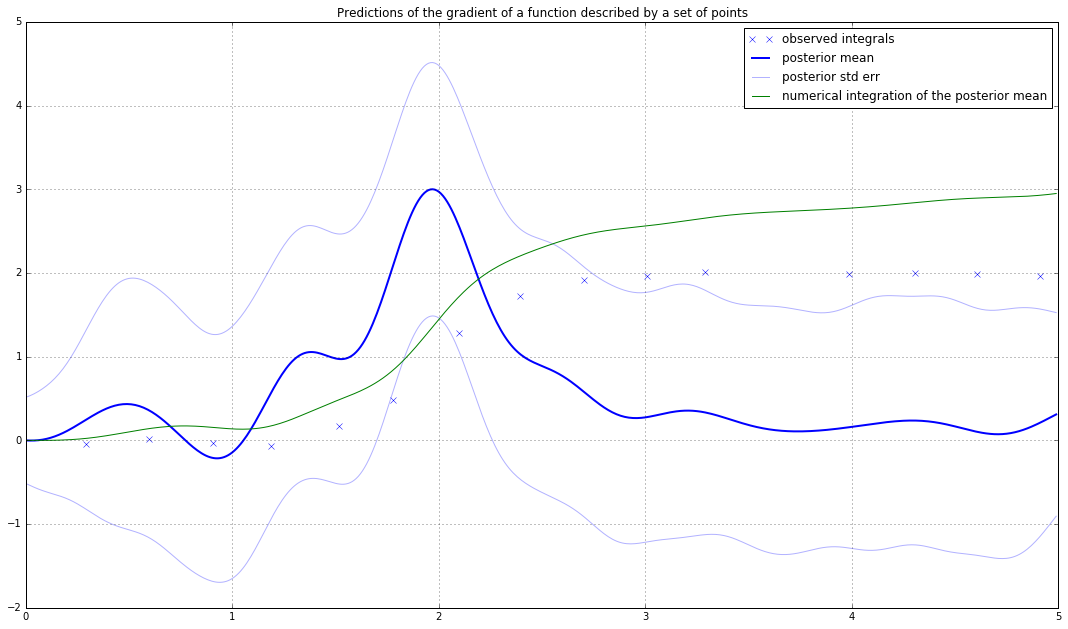

In [451]:
plt.plot(ts,xs,'x',label='observed integrals')
plt.plot(fts,mean,'b',linewidth=2,label='posterior mean')
stds = np.sqrt(cov.diagonal())
plt.plot(fts,mean+stds,'b', alpha=0.3,label='posterior std err')
plt.plot(fts,mean-stds,'b', alpha=0.3)
plt.grid()
plt.plot(fts,np.cumsum(mean)*(fts[1]-fts[0]),linewidth=1,label='numerical integration of the posterior mean')
plt.legend()
plt.title('Predictions of the gradient of a function described by a set of points')
plt.xlim([0,5])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

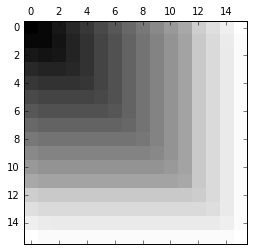

In [452]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.matshow(K_xx,cmap='gray')

Things to note:

 - There seems to be a bias, this might be still because of the missing C?
 - The observed values are assumed to be the integral between 0 and t: For the example above (for differential privacy etc) we are integrating each time window, so we need to add the integrals together.
 - I need to add the variance in each observation - currently it's quite fragile.
 - I noticed when the length scale was short, uncertainty in the posterior mean (logically) decreased in proximity to a data point, but it decreased even more a long way from the data: I don't understand where I've made assumptions about that prior uncertainty?

In [466]:
step = 0.2
ts = np.hstack([np.arange(0,3.5,step),np.arange(4,5,step)])
xs = np.cos(ts*4) #sine
l = 0.1
K_ff = np.zeros([fts.shape[0],fts.shape[0]])
K_xf = np.zeros([fts.shape[0],ts.shape[0]])
K_xx = np.zeros([ts.shape[0],ts.shape[0]])

for i,t in enumerate(ts):
    for j,ft in enumerate(fts):
        K_xf[j,i] = k_xf(ft,t,l)
    
    for j,t2 in enumerate(ts):
        K_xx[i,j] = k_xx(t2,t,l)

for i,ft in enumerate(fts):
    for j,ft2 in enumerate(fts):
        K_ff[i] = k_xf(ft2,ft,l)

mean, cov = get_GP_reg(K_ff,K_xf,xs)

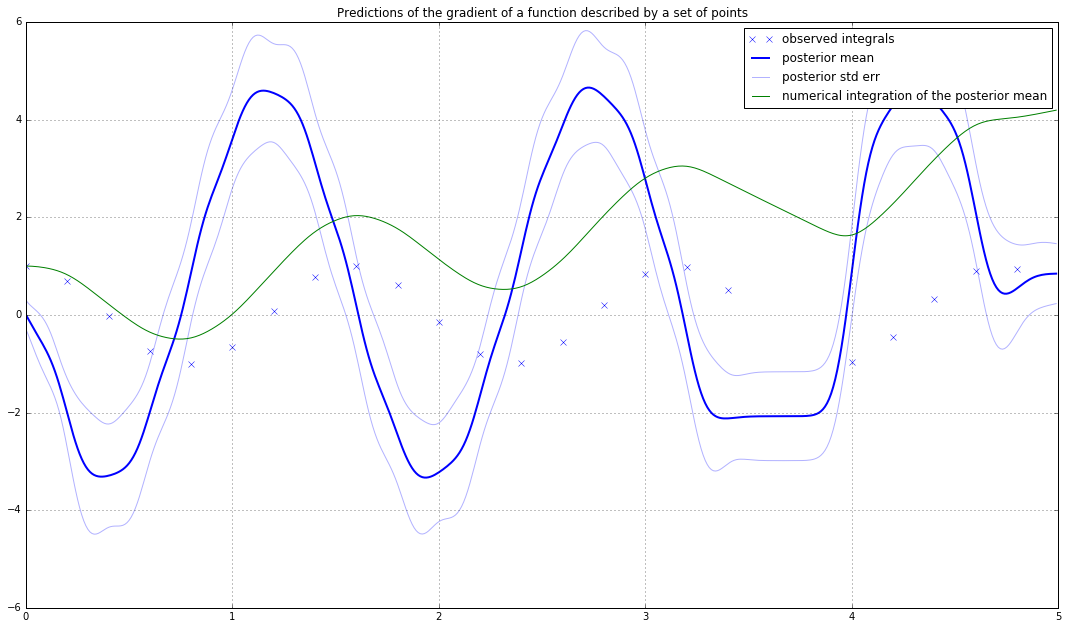

In [467]:
plt.plot(ts,xs,'x',label='observed integrals')
plt.plot(fts,mean,'b',linewidth=2,label='posterior mean')
stds = np.sqrt(cov.diagonal())
plt.plot(fts,mean+stds,'b', alpha=0.3,label='posterior std err')
plt.plot(fts,mean-stds,'b', alpha=0.3)
plt.grid()
plt.plot(fts,np.cumsum(mean)*(fts[1]-fts[0])+xs[0],linewidth=1,label='numerical integration of the posterior mean')
plt.legend()
plt.title('Predictions of the gradient of a function described by a set of points')
plt.xlim([0,5])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [468]:
N = 100
age = np.random.rand(N,1)*18 #ages (months)
weight = 3 + 10.0*np.sqrt(age) + np.random.randn(N,1)*4 #weight (kg)

In [469]:
blocksize = 3
ageblocks = np.arange(0,18,blocksize)
weightblocks = np.zeros_like(ageblocks)
for i,ab in enumerate(ageblocks):
    data = weight[(age>ab) & (age<ab+blocksize)]
    weightblocks[i] = np.mean(data) + np.random.laplace(0,scale=(50/len(data))) #todo use cleverer mechanism

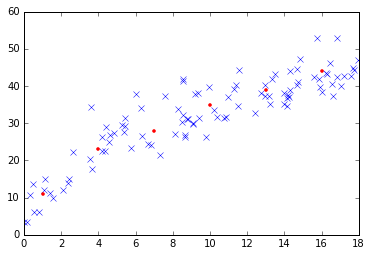

In [470]:
plt.plot(age,weight,'x');
plt.plot(ageblocks+blocksize/2, weightblocks, '.r')

In [538]:
ts = ageblocks
xs = np.cumsum(weightblocks)
#offset = xs[0]
#xs -= offset


#gradient = 1.0*(xs[1]-xs[0])/(ts[1]-ts[0])
#xs = xs - gradient * ts


fts = np.arange(0,18,0.1)

#Covariance matrices
K_ff = np.zeros([fts.shape[0],fts.shape[0]])
K_xf = np.zeros([fts.shape[0],ts.shape[0]])
K_xx = np.zeros([ts.shape[0],ts.shape[0]])

l = 0.2
for i,t in enumerate(ts):
    for j,ft in enumerate(fts):
        K_xf[j,i] = k_xf(ft,t,l)
    
    for j,t2 in enumerate(ts):
        K_xx[i,j] = k_xx(t2,t,l)

for i,ft in enumerate(fts):
    for j,ft2 in enumerate(fts):
        K_ff[i] = k_xf(ft2,ft,l)

mean, cov = get_GP_reg(K_ff,K_xf,xs)
#mean = mean + gradient * fts
#mean = mean + offset
#xs += gradient * ts
#xs += offset

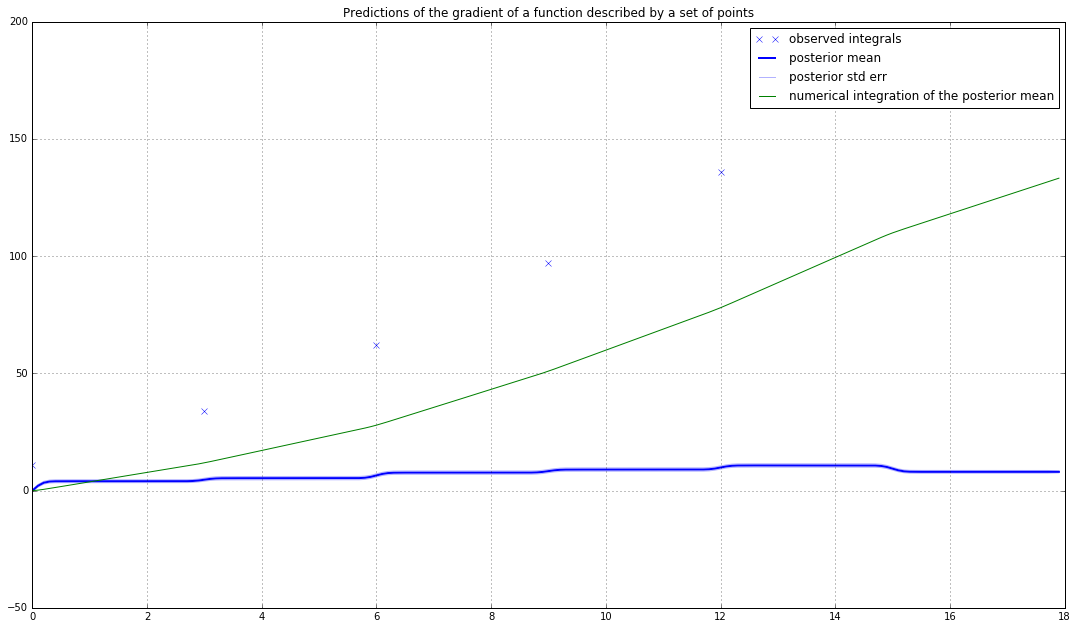

In [539]:
plt.plot(ts,xs,'x',label='observed integrals')
plt.plot(fts,mean,'b',linewidth=2,label='posterior mean')
stds = np.sqrt(cov.diagonal())
plt.plot(fts,mean+stds,'b', alpha=0.3,label='posterior std err')
plt.plot(fts,mean-stds,'b', alpha=0.3)
plt.grid()
plt.plot(fts,np.cumsum(mean)*(fts[1]-fts[0]),linewidth=1,label='numerical integration of the posterior mean')
plt.legend()
plt.title('Predictions of the gradient of a function described by a set of points')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

This currently doesn't work - probably due to the constant factor missing, etc?

In general I've forgotten the point - why aren't we just using the means?

Do we need to do something clever so the limits of each point aren't from 0 to t?